In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Step 1 : Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
nx = 9
ny = 6
cal_dir = './camera_cal/calibration*.jpg'


def get_cal_points(directory, nx, ny):
    # prepare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(directory)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

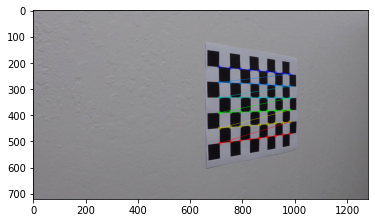

In [3]:
objpoints, imgpoints = get_cal_points(cal_dir, nx, ny)

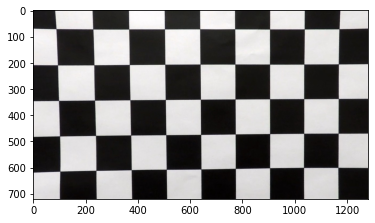

In [4]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistorted)

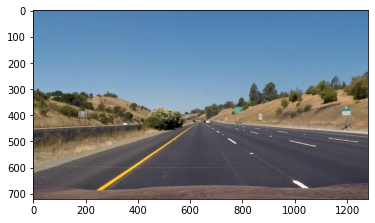

In [5]:
image = mpimg.imread('./test_images/straight_lines1.jpg')
plt.imshow(image)

# STEP 2: Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    This function identifies pixels in an image where the gradient
    falls into a certain threshold range
    
    Arguments:
        image - an RGB image (this function assumes mpimg.imread() is used)
        orient - the orient of the gradient that is analyzed
        sobel_kernel - the kernel size of the sobel operator
        thresh - the threshold for pixel range
        
    Returns:
        grad_binary - binary output image where thresholds were met
    """
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    This function applies a threshold to the overall magnitude of
    the gradient in either x or y.
    
    Arguments:
        image - an RGB image (this function assumes mpimg.imread() is used)
        sobel_kernel - the kernel size of the sobel operator
        mag_thresh - the threshold for pixel range
        
    Returns:
        mag_binary - binary output image where thresholds were met
    
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    This function computes the direction of the gradient
    and applies a threshold.
    
    Arguments:
        image - an RGB image (this function assumes mpimg.imread() is used)
        sobel_kernel - the kernel size of the sobel operator
        thresh - the threshold for gradient direction
        
    Returns:
        mag_binary - binary output image where thresholds were met
    
    """
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

def hls_select(image, thresh=(0, 255)):
    """
    This function isolates the S channel from the  HLS color space of an image and 
    applies a threshold.
    
    Arguments:
        image - an RGB image (this function assumes mpimg.imread() is used)
        thresh - the treshold to apply
        
    Returns:
        hls_binary - binary output image where thresholds were met
    """
    
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    hls_binary = np.zeros_like(s_channel)
    hls_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return hls_binary

# Test our functions

## The following sections test the functions for applying certain thresholds in different color spaces

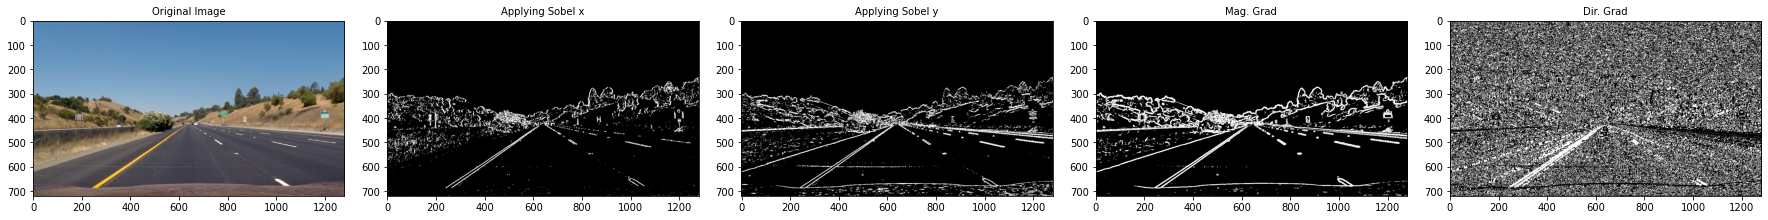

In [7]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Applying Sobel x', fontsize=10)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Applying Sobel y', fontsize=10)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Mag. Grad', fontsize=10)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Dir. Grad', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

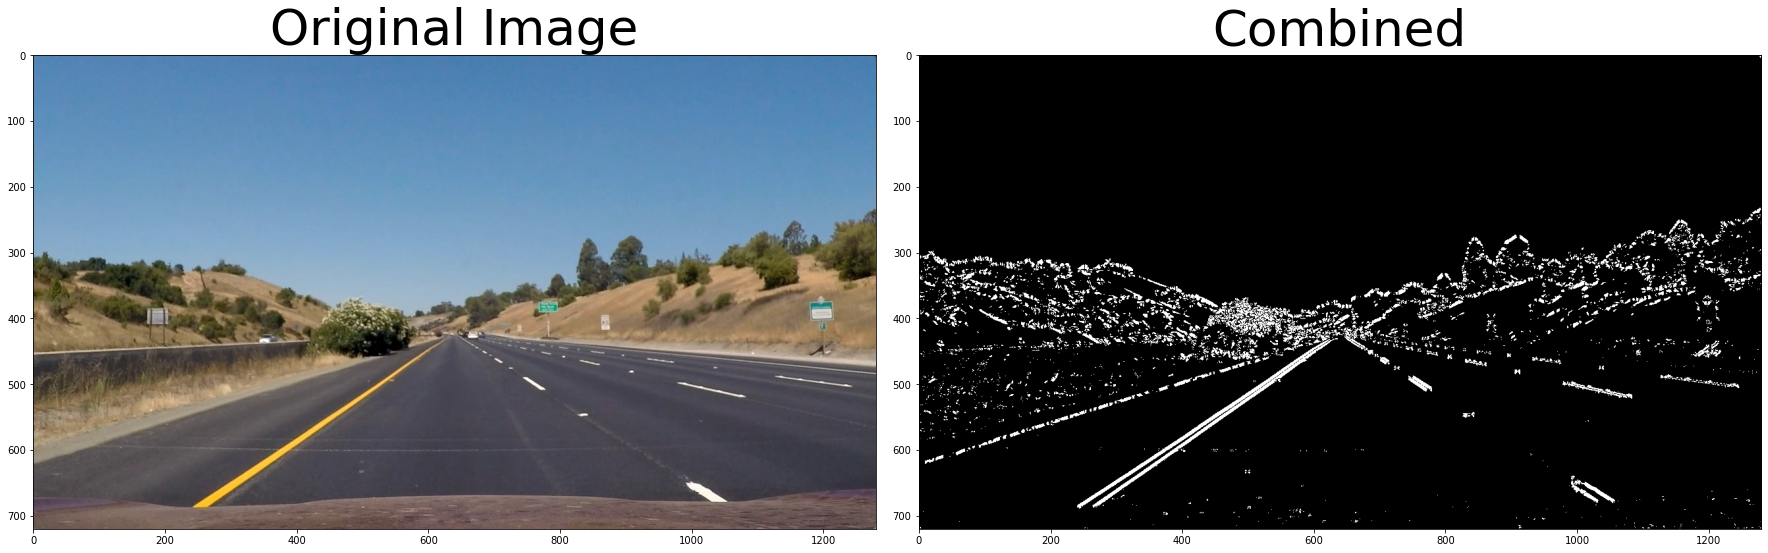

In [8]:
# Plot the combined result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

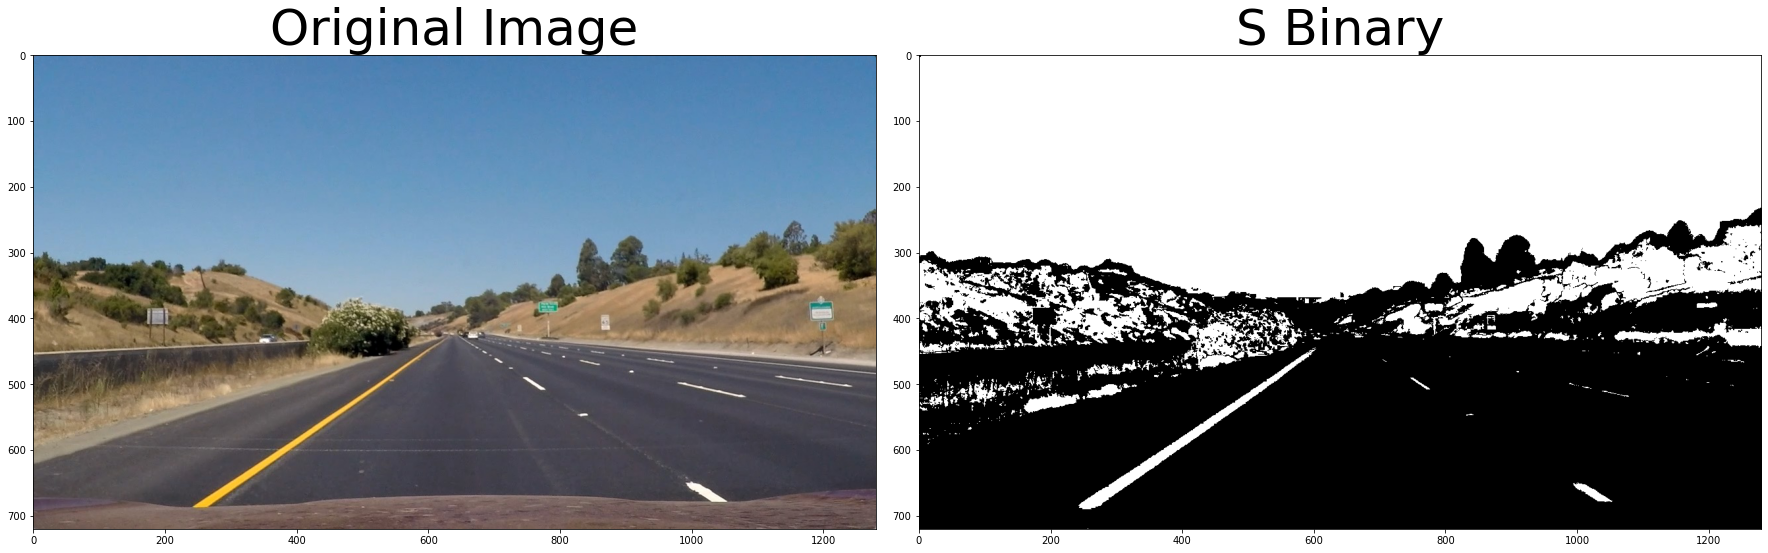

In [9]:
hls_binary = hls_select(image, thresh=(70, 255))

# Plot the S binary result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('S Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

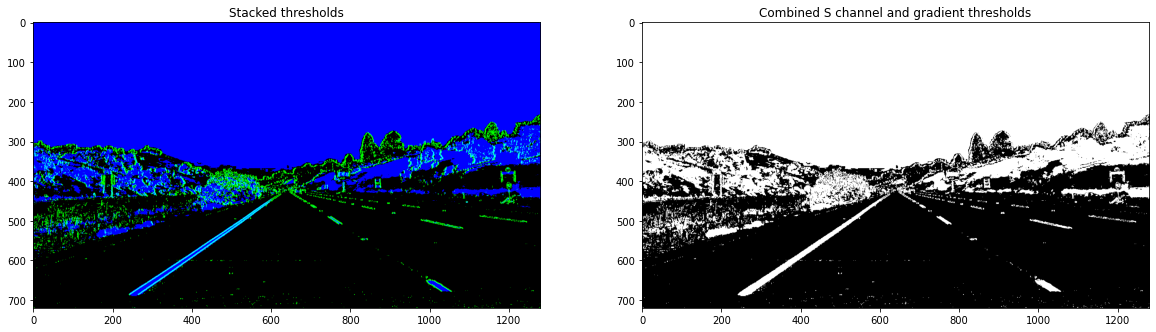

In [10]:
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 255))

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradx)
combined_binary[(hls_binary == 1) | (gradx == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Step 3: Apply a perspective transform to rectify binary image ("birds-eye view")


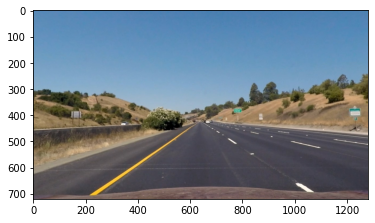

In [11]:
undistorted = cal_undistort(image, objpoints, imgpoints)
plt.imshow(undistorted)

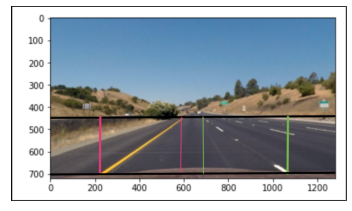

In [21]:
roi_src = np.float32([[200,720],[image.shape[1]/2 - 55, 460],[image.shape[1]/2 + 55, 460],[1130, 720]])
roi_dst = np.float32([[320,720],[320,0],[960,0],[960,720]])
roi_image = mpimg.imread('./output_images/roi_coordinates.png')
fig = plt.imshow(roi_image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [22]:
def warp_image(undist, src, dst):
    """
    This function takes an undistorted image and warps it.
    
    Arguments:
        undist - an undistorted RGB image
        src - a numpy array of float source coordinates
        dst - a numpy array of float destination coordinates
        
    Returns:
        warped - the warped image
        M - the perspective transform of the image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped, M

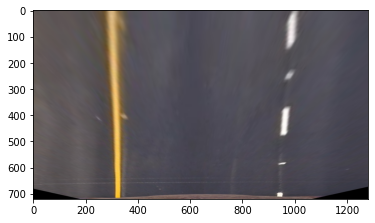

In [23]:
warped, M = warp_image(undistorted, roi_src, roi_dst)
plt.imshow(warped)

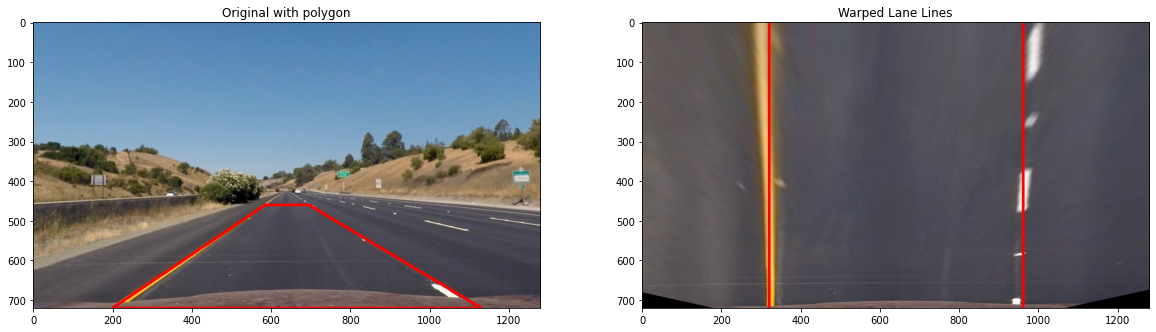

In [24]:
# Turn roi_coordinates into integers so cv2.polylines can read them
draw_image = np.copy(undistorted)
pts = np.int32(roi_src)
pts = pts.reshape((-1,1,2))
overlay_image = cv2.polylines(draw_image,[pts],True,(255,0,0),thickness=5)

draw_warped = np.copy(warped)
left_bottom = (320,720)
left_top = (320,0)
right_bottom = (960,720)
right_top = (960,0)

overlay_warped = cv2.line(draw_warped, left_bottom, left_top, (255,0,0), thickness=5)
overlay_warped = cv2.line(draw_warped, right_bottom, right_top, (255,0,0), thickness=5)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original with polygon')
ax1.imshow(overlay_image)

ax2.set_title('Warped Lane Lines')
ax2.imshow(overlay_warped)

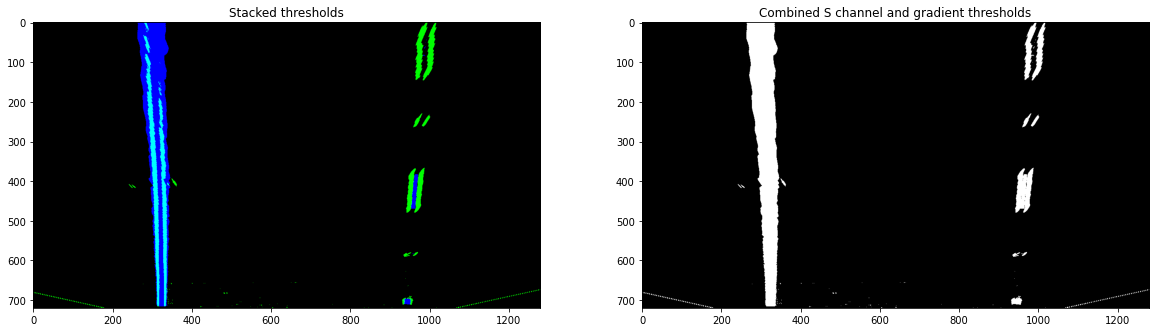

In [25]:
hls_binary = hls_select(warped, thresh=(70, 255))
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 255))
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255
combined_binary = np.zeros_like(gradx)
combined_binary[(hls_binary == 1) | (gradx == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')


# Step 4: Detect lane pixels and fit to find the lane boundary.

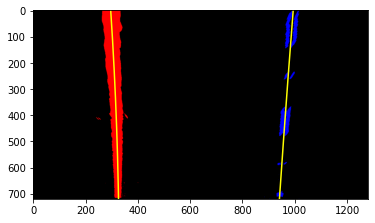

In [31]:
def find_lane_pixels(binary_warped):
    """
    This function takes a binary warped image and finds lane pixels
    using sliding windows
    
    Arugments:
        binary_warped - a binary warped image
        
    Returns:
        leftx - left line x pixel positions
        lefty - left line y pixel positions
        rightx - right line x pixel positions
        righty - right line y pixel positions
        out_img - stacked image that is used for drawing
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    """
    This function fits a polynomial onto found line pixels of a binary image
    
    Arguments:
        binary_warped - a binary warped image
        
    Returns:
        out_img - an image with drawn polynomials on found line pixels
    """
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [32]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER: width of the margin to search around
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Setting search areas for finding pixels based on previously found pixels
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

NameError: name 'left_fit' is not defined

# Step 5: Determine the curvature of the lane and vehicle position with respect to center.
